In [88]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
import joblib
import pickle
# Import required libraries
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
from src.data.data_loader import load_raw_data
from src.features.feature_engineering import FeatureEngineering, FlagClusteringTransformer,PreprocessingFeaturesTransformer, PreprocessingFeatures
from category_encoders import TargetEncoder


In [89]:
raw_data = load_raw_data('../../data/raw/raw_data.csv')

2025-08-10 16:49:53,847 - src.data.data_loader - INFO - Successfully loaded 48665 rows from ../../data/raw/raw_data.csv


In [90]:
feat_to_drop = [
    "cd_type_individual",
    "cd_advertise",
    "cd_client",
    "flg_rain_sensor",
    "flg_diesel",
    "flg_eletrico",
    "flg_benzina",
    "flg_pcd",
    "flg_trade_in",
    "flg_armored",
    "flg_factory_warranty",
    "flg_all_dealership_schedule_vehicle",
    "flg_all_dealership_services",
    "flg_single_owner",
    "priority",
    "cd_model_vehicle",
    "cd_version_vehicle",
]

pipeline_pre = Pipeline([
    ('preprocessing', PreprocessingFeaturesTransformer(
        location_col="city_state",
        fuel_type_column="fuel_type",
        cols_to_drop=feat_to_drop,
        outlier_columns=[
           "vl_advertise", "km_vehicle"
        ]
    )),
    ('feat_engineering', FlagClusteringTransformer(feature_flag_cols = [
        "flg_gasolina",
        "flg_electric_locks",
        "flg_air_conditioning",
        "flg_electric_windows",
        "flg_rear_defogger",
        "flg_heater",
        "flg_alarm",
        "flg_airbag",
        "flg_abs",
    ])),       
])

In [91]:
df_processed = pipeline_pre.fit_transform(
            raw_data)

2025-08-10 16:49:53,893 - src.features.feature_engineering - INFO - 📈 Numerical features: 5
2025-08-10 16:49:53,894 - src.features.feature_engineering - INFO - 🏷️ Categorical features: 35
2025-08-10 16:49:53,895 - src.features.feature_engineering - INFO - 🎯 Target variable: ['flg_leads', 'leads']
2025-08-10 16:49:53,896 - src.features.feature_engineering - INFO - Runnig location split...
2025-08-10 16:49:57,461 - src.features.feature_engineering - INFO - Converting flag columns to integer type...
2025-08-10 16:49:57,650 - src.features.feature_engineering - INFO - Flag columns converted to integer type successfully
2025-08-10 16:49:57,650 - src.features.feature_engineering - INFO - Converting fuel type to flag columns...
2025-08-10 16:49:57,653 - src.features.feature_engineering - INFO - Found 7 unique fuel types: ['alcool', 'gasolina', 'gas', 'natural', 'diesel', 'eletrico', 'benzina']
2025-08-10 16:49:57,747 - src.features.feature_engineering - INFO - Removing duplicate columns...
202

In [92]:

# Check column names before applying TargetEncoder
print("Columns in df_processed:", df_processed.columns)

# Create pipeline with TargetEncoder for specific columns
pipeline = Pipeline(steps=[
    ('encoding', ColumnTransformer(
        transformers=[
            ('city', TargetEncoder(cols=['city'], smoothing=0.5, min_samples_leaf=1000), ['city']),
            ('state', TargetEncoder(cols=['state'], smoothing=5, min_samples_leaf=500), ['state']),
            ('scaler', StandardScaler(), ['views', 'phone_clicks', 'vl_advertise', 'km_vehicle', 'vl_market']),
            ('transmission', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['transmission_type'])
        ],
        remainder='passthrough'  # Keep the other columns unchanged
    )),
])

# Fit the pipeline
X = df_processed.drop('leads', axis=1)  # Features
y = df_processed['leads']  # Target

# Fit and transform
X_transformed = pipeline.fit_transform(X, y)

Columns in df_processed: Index(['leads', 'views', 'phone_clicks', 'cd_vehicle_brand', 'year_model',
       'zip_2dig', 'vl_advertise', 'n_photos', 'km_vehicle', 'vl_market',
       'flg_lincese', 'flg_tax_paid', 'transmission_type', 'n_doors',
       'flg_leather_seats', 'flg_alloy_wheels', 'flg_parking_sensor', 'city',
       'state', 'flg_alcool', 'flg_gas_natural', 'flag_cluster'],
      dtype='object')


In [93]:


# Criar DataFrame com os dados transformados e os nomes das colunas
X_transformed_df = pd.DataFrame(X_transformed, columns=list(X.columns))

X_transformed_df

,views,phone_clicks,cd_vehicle_brand,year_model,zip_2dig,vl_advertise,n_photos,km_vehicle,vl_market,flg_lincese,...,transmission_type,n_doors,flg_leather_seats,flg_alloy_wheels,flg_parking_sensor,city,state,flg_alcool,flg_gas_natural,flag_cluster
0,4.418852,2.567132,-0.403753,-0.651688,1.078244,-0.805788,NaN,NaN,34.0,2018.0,...,7.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,2.0
1,4.418852,6.606707,-0.403753,-0.302442,-0.924955,7.371108,NaN,5.0,2.0,1996.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0
2,9.757325,6.606707,-0.403753,0.308739,-0.329984,-0.406317,NaN,5.0,30.0,2002.0,...,4.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0
3,9.757325,6.606707,-0.403753,0.570673,-0.228546,0.438856,NaN,1.0,10.0,1995.0,...,8.0,1.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
4,9.757325,6.606707,-0.403753,0.308739,-0.501648,0.038673,NaN,1.0,12.0,1995.0,...,6.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48542,4.418852,6.606707,30.493579,-0.651688,-0.150517,-0.390907,-0.114568,5.0,280.0,2016.0,...,8.0,0.0,0.0,4.0,1.0,1.0,1.0,0.0,0.0,4.0
48543,4.418852,4.084837,40.313044,-0.651688,-0.248054,0.275535,-0.233821,5.0,4.0,2013.0,...,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,3.0
48544,4.418852,6.606707,63.787930,-0.651688,0.744865,0.616662,0.700914,1.0,5.0,2012.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,2.0
48545,4.418852,6.606707,74.561865,-0.651688,-0.037375,-0.331638,-0.168005,1.0,2.0,2014.0,...,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,1.0


In [103]:

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
# Train-test split (80% train, 20% test)

# Fit the pipeline
X = df_processed.drop('leads', axis=1)  # Features
y = df_processed['leads']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the column names to ensure all required columns exist
print("Columns in X_train:", X_train.columns)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('encoding', ColumnTransformer(
        transformers=[
            ('city', TargetEncoder(cols=['city'], smoothing=0.5, min_samples_leaf=1000), ['city']),
            ('state', TargetEncoder(cols=['state'], smoothing=5, min_samples_leaf=500), ['state']),
            ('scaler', StandardScaler(), ['views', 'phone_clicks', 'vl_advertise', 'km_vehicle', 'vl_market']),
            ('transmission', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['transmission_type'])
        ],
        remainder='passthrough'  # Keep the other columns unchanged
    )),
    ('model', LGBMRegressor(learning_rate=0.01, reg_alpha=1, num_leaves=20, max_depth=10, n_estimators=300))  # LightGBM Regressor
])

# Set up K-fold cross-validation with stratification on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Apply cross-validation to evaluate the model on the training set
cross_val_results = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')

# Print cross-validation results
print(f"Cross-validation results (Negative MSE): {cross_val_results}")
print(f"Mean of Negative MSE: {cross_val_results.mean()}")
print(f"Standard deviation of Negative MSE: {cross_val_results.std()}")

# Optionally: Calculate the RMSE (Root Mean Squared Error)
rmse_scores = (-cross_val_results) ** 0.5  # Convert negative MSE to positive RMSE
print(f"RMSE scores for each fold: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Standard deviation of RMSE: {rmse_scores.std()}")

# After cross-validation, evaluate the model on the test set (not part of cross-validation)
pipeline.fit(X_train, y_train)  # Fit the pipeline on the full training data
y_pred = pipeline.predict(X_test)  # Predict on the test data


Columns in X_train: Index(['views', 'phone_clicks', 'cd_vehicle_brand', 'year_model', 'zip_2dig',
       'vl_advertise', 'n_photos', 'km_vehicle', 'vl_market', 'flg_lincese',
       'flg_tax_paid', 'transmission_type', 'n_doors', 'flg_leather_seats',
       'flg_alloy_wheels', 'flg_parking_sensor', 'city', 'state', 'flg_alcool',
       'flg_gas_natural', 'flag_cluster'],
      dtype='object')
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 31069, number of used features: 21
[LightGBM] [Info] Start training from score 4,401107
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

In [104]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'model__num_leaves': [31, 50, 70],  # Number of leaves in each tree
#     'model__learning_rate': [0.01],  # Learning rate
#     'model__max_depth': [-1, 5, 10],  # Max depth of each tree
#     'model__min_data_in_leaf': [ 30, 50],  # Min data in each leaf
#     'model__subsample': [0.7, 0.8],  # Subsample fraction
#     'model__colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
#     'model__boosting_type': ['gbdt', 'dart', 'goss'],  # Type of boosting
#     'model__feature_fraction': [0.6, 0.8, 1.0]  # Fraction of features used
# }

# # Set up GridSearchCV with the pipeline and hyperparameter grid
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Best parameters and score
# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best score: {grid_search.best_score_}")

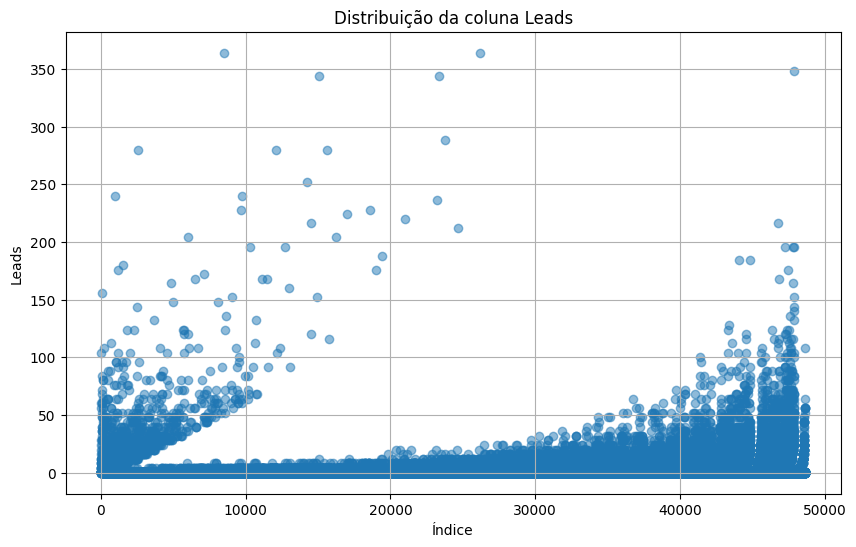

In [105]:
# Supondo que 'df_processed' seja seu DataFrame
plt.figure(figsize=(10, 6))

# Scatter plot da coluna 'leads'
plt.scatter(df_processed.index, df_processed['leads'], alpha=0.5)
plt.title('Distribuição da coluna Leads')
plt.xlabel('Índice')
plt.ylabel('Leads')
plt.grid(True)
plt.show()

Test MSE: 43.3431
Test RMSE: 6.5836
Test MAE: 3.0689
Test R2: 0.7134


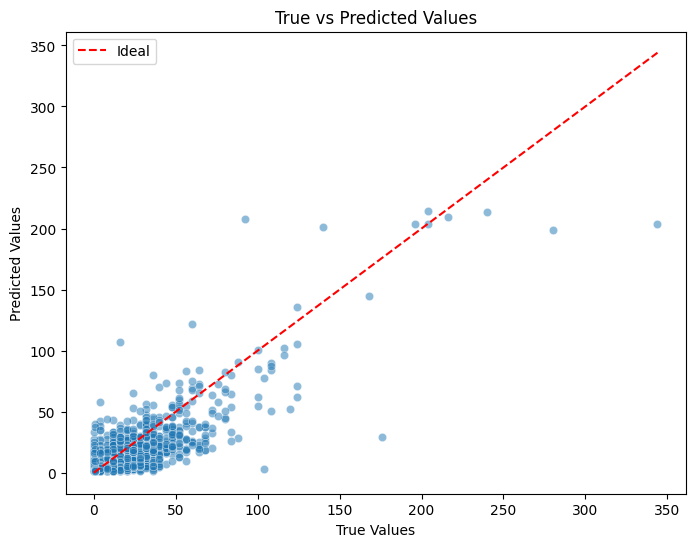

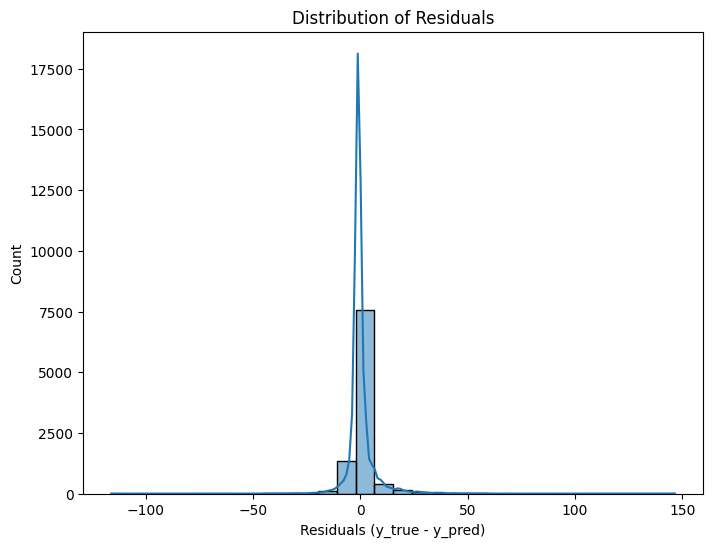

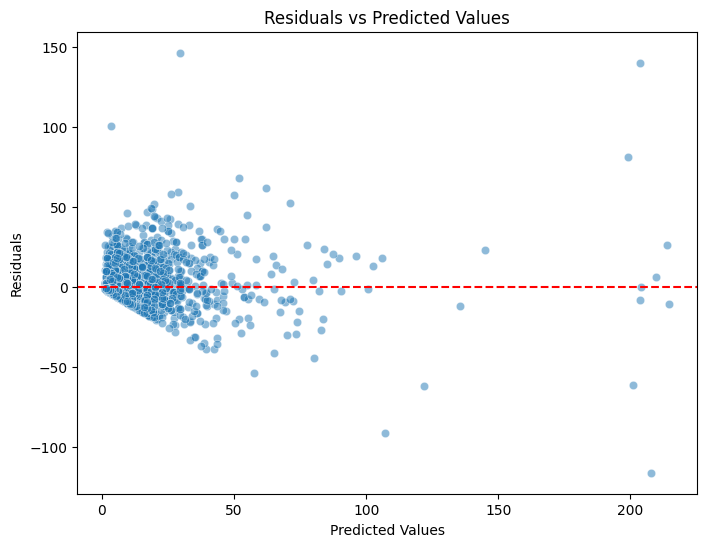

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliação no conjunto de teste
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2: {r2:.4f}")

# Plot: y_test vs y_pred (scatter)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

# Plot: Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals (y_true - y_pred)')
plt.title('Distribution of Residuals')
plt.show()

# Plot: Residuals vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

## Avaliação de Curva de Aprendizado e Overfitting

Vamos plotar a curva de aprendizado (learning curve) para avaliar se há overfitting/underfitting e também reforçar a análise com o scatter plot de valores reais vs preditos.

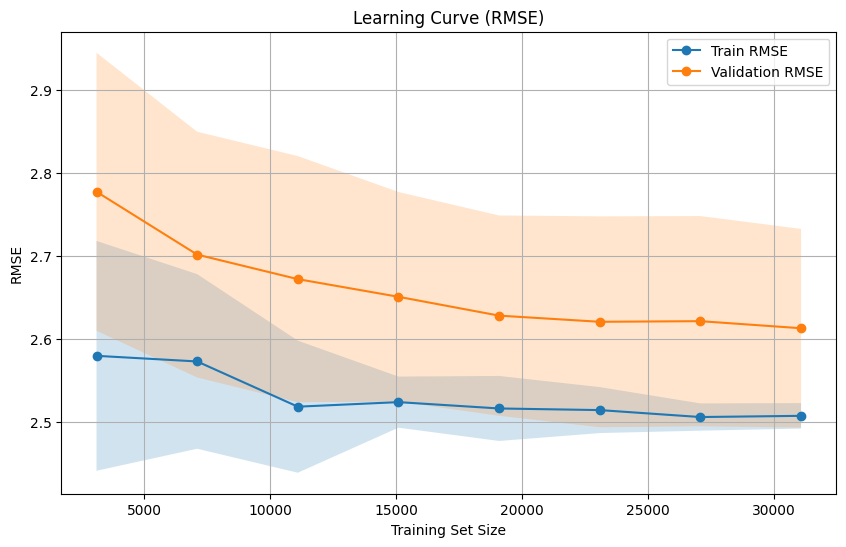

✅ Sem sinais claros de overfitting.


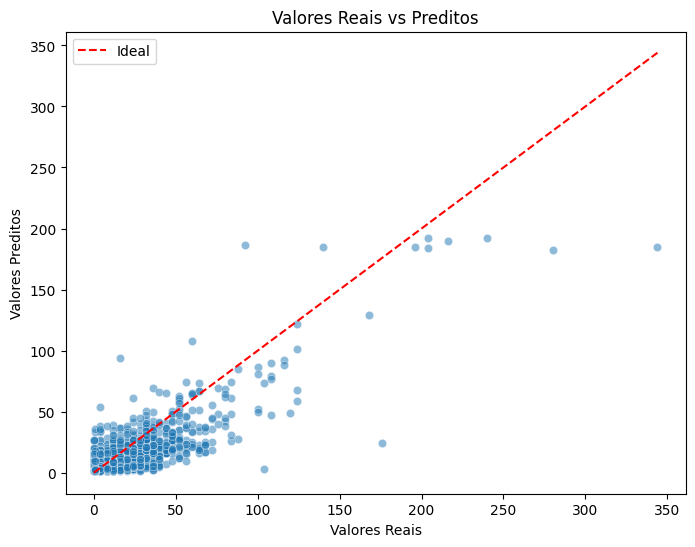

In [98]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Gerar curva de aprendizado
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train,
    cv=5,
    scoring='neg_root_mean_squared_error',  # Use RMSE as scoring metric
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_rmse = (-train_scores) ** 0.5
test_rmse = (-test_scores) ** 0.5

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', label='Train RMSE')
plt.plot(train_sizes, test_rmse.mean(axis=1), 'o-', label='Validation RMSE')
plt.fill_between(train_sizes, train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                 train_rmse.mean(axis=1) + train_rmse.std(axis=1), alpha=0.2)
plt.fill_between(train_sizes, test_rmse.mean(axis=1) - test_rmse.std(axis=1),
                 test_rmse.mean(axis=1) + test_rmse.std(axis=1), alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (RMSE)')
plt.legend()
plt.grid(True)
plt.show()

# Diagnóstico visual de overfitting
if test_rmse.mean(axis=1)[-1] - train_rmse.mean(axis=1)[-1] > 0.1 * train_rmse.mean(axis=1)[-1]:
    print('⚠️ Possível overfitting detectado: diferença significativa entre erro de treino e validação.')
else:
    print('✅ Sem sinais claros de overfitting.')

# Scatter plot já está presente na célula anterior, mas reforçando:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs Preditos')
plt.legend()
plt.show()